In [1]:
from devito import *
from AI4Advection import AI4Advection, AI4Diffusion
from examples.cfd import  plot_field
import numpy as np
import torch
import matplotlib.pyplot as plt

## prepare data

torch.Size([1, 1, 64, 64])


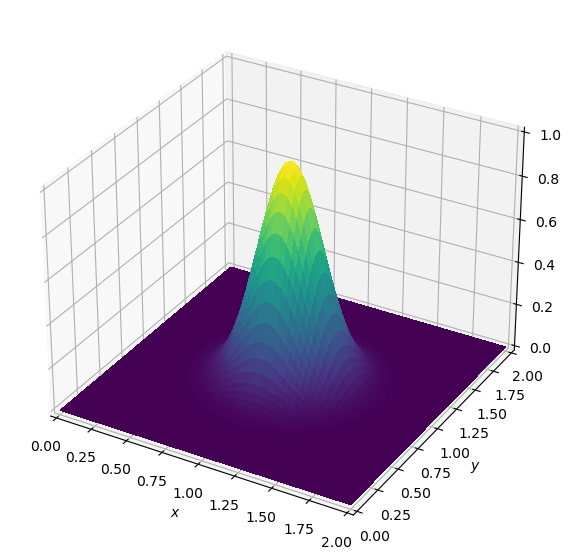

In [3]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
nx = 64
ny = 64
length = 2.
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_df = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_df[0,0,:,:].detach(),f'./diffusion_equation_result/DF0.pt')
print(u_tensor_init_df.shape)
plot_field(u.data[0])



## Diffusion model

In [6]:
model_diff = AI4Diffusion(u = u_tensor_init_df, dx = length/nx, dy = length/ny, D = 5, nx = nx, ny = ny,dt = dt)

In [7]:
model_diff.forward(4)

tensor([[[[0.0311, 0.0330, 0.0362,  ..., 0.0362, 0.0330, 0.0311],
          [0.0330, 0.0350, 0.0382,  ..., 0.0382, 0.0350, 0.0330],
          [0.0362, 0.0382, 0.0415,  ..., 0.0415, 0.0382, 0.0362],
          ...,
          [0.0362, 0.0382, 0.0415,  ..., 0.0415, 0.0382, 0.0362],
          [0.0330, 0.0350, 0.0382,  ..., 0.0382, 0.0350, 0.0330],
          [0.0311, 0.0330, 0.0362,  ..., 0.0362, 0.0330, 0.0311]]]],
       grad_fn=<AddBackward0>)

### Data generation

In [23]:
u_tensor = u_tensor_init_df
for i in range(1,nt):
    model_diff = AI4Diffusion(u = u_tensor, dx = length/nx, dy = length/ny, D = 5, nx = nx, ny = ny,dt = dt)
    result = model_diff.forward(4)
    u_tensor = result
    torch.save(u_tensor[0,0,:,:].detach(),f'./diffusion_equation_result/DF{i}.pt')

### virtualization

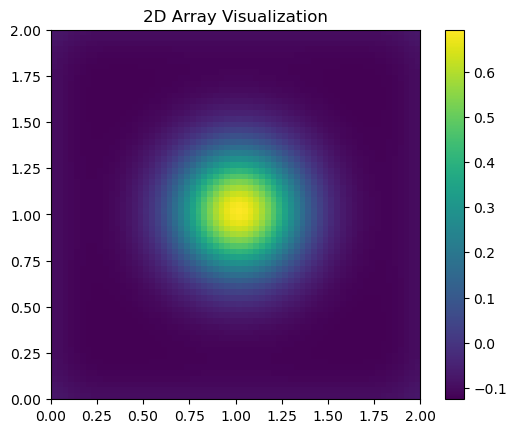

In [24]:
import matplotlib.pyplot as plt
test = torch.load('./diffusion_equation_result/DF3.pt')
# centre = test[1:-1,1:-1]
# centre = (centre-centre.min()) / (centre.max() - centre.min())
plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

In [28]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 加载张量数据
tensors = []
for i in range(1, nt):
    tensor = torch.load(f'./diffusion_equation_result/DF{i}.pt')
    tensors.append(tensor)

# 创建动画
fig, ax = plt.subplots()
def update(frame):
    global cbar
    ax.clear()
    data = tensors[frame].detach().numpy()
    cax = ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {frame}')
    return cax

anim = FuncAnimation(fig, update, frames=len(tensors), interval=200, blit=False)

# 显示动画
plt.close(fig)  # 防止显示静态图
HTML(anim.to_jshtml())

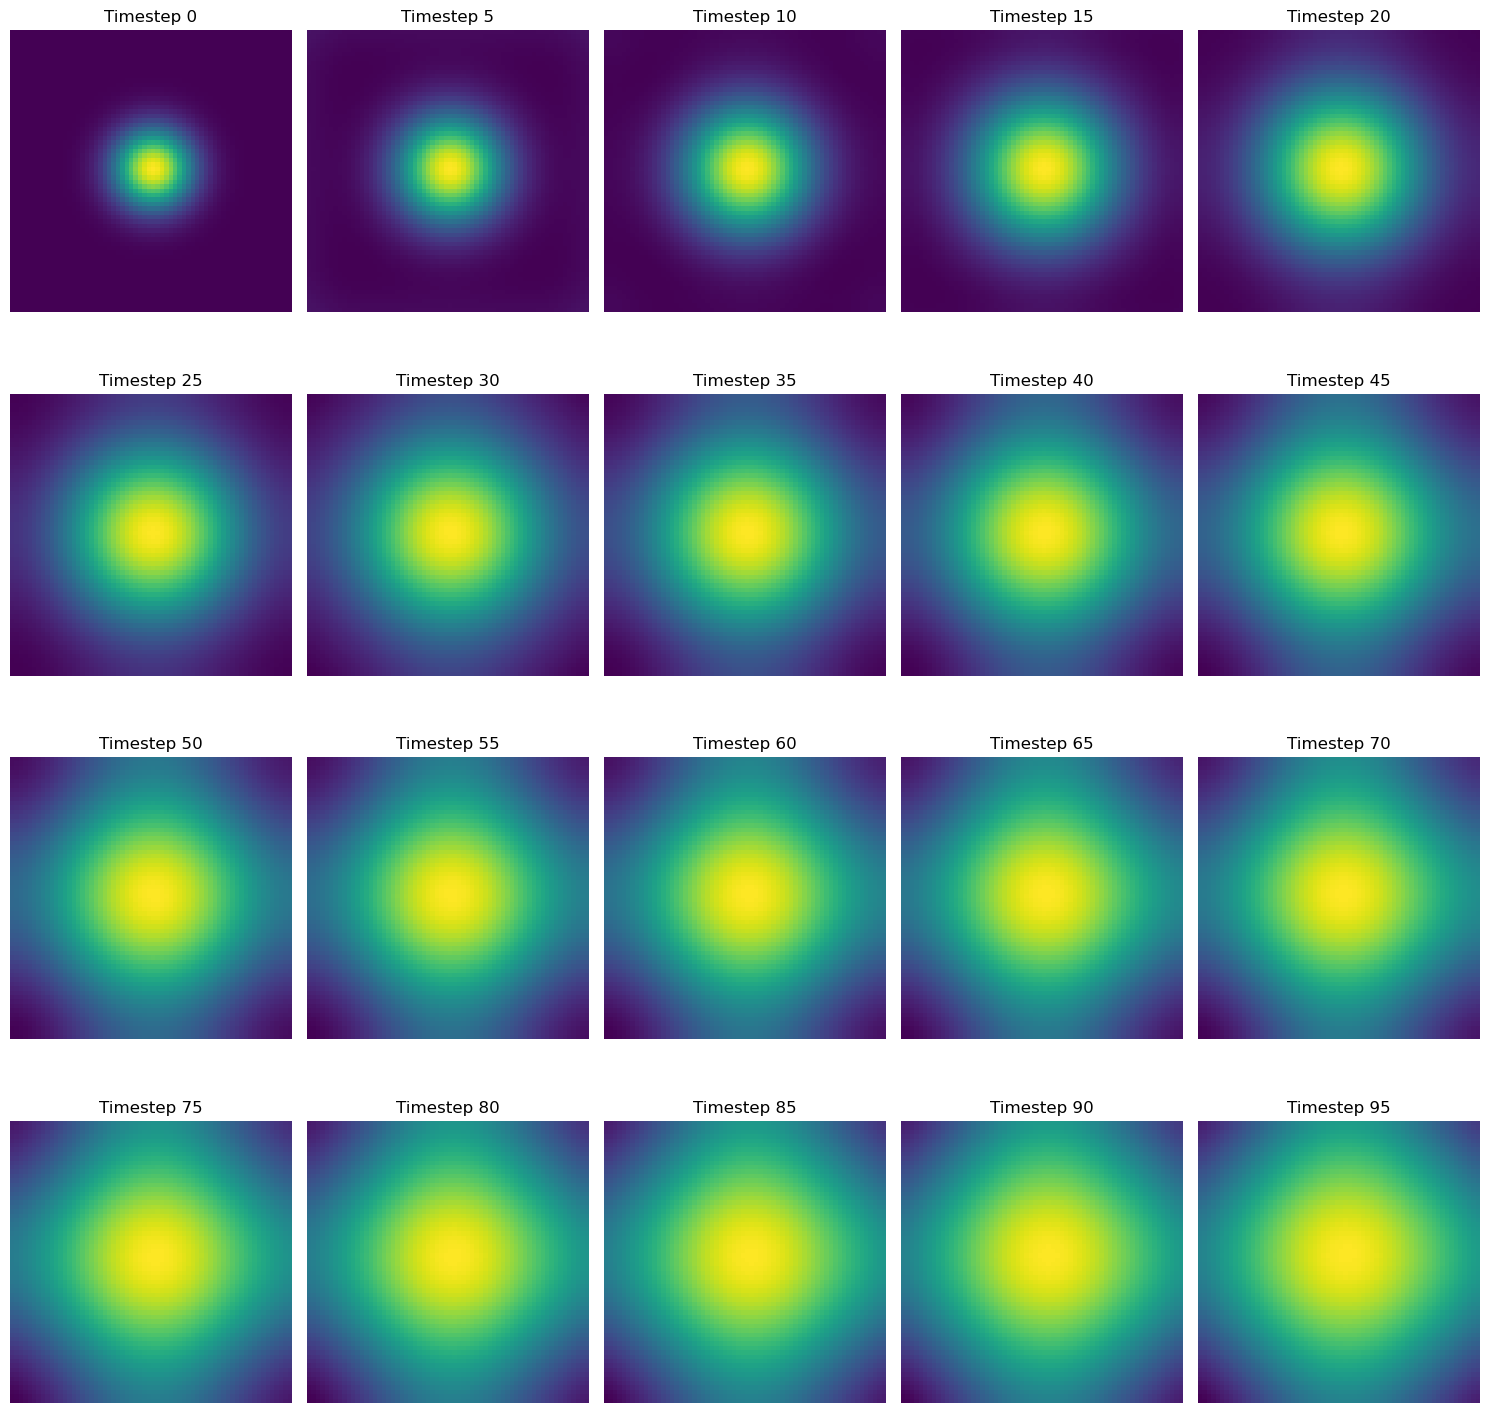

In [30]:
tensors = []
for i in range(0, nt, 5):
    tensor = torch.load(f'./diffusion_equation_result/DF{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()